In [1]:
import os
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, LearningRateScheduler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import time
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

In [3]:
    class DataGenerator(Sequence):
    def __init__(self, X_path, y_path, indices, batch_size):
        assert os.path.exists(X_path), f"X_path {X_path} does not exist."
        assert os.path.exists(y_path), f"y_path {y_path} does not exist."
        
        self.X = np.memmap(X_path, dtype='float32', mode='r', shape=(1612, 15, 224, 224, 3))
        self.y = np.memmap(y_path, dtype='int32', mode='r', shape=(1612,))
        self.indices = indices
        self.batch_size = batch_size

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch = self.X[batch_indices]
        X_batch = preprocess_input(X_batch)
        y_batch = np.eye(2)[self.y[batch_indices]]
        return X_batch, y_batch
    
class StepTimerCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\n--- Starting Epoch {epoch + 1} ---")
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        print(f"--- Epoch {epoch + 1} completed in {epoch_time:.2f} seconds ---\n")

    def on_train_batch_begin(self, batch, logs=None):
        self.step_start_time = time.time()
        print(f"Step {batch + 1}/{self.params['steps']} - ", end="")

    def on_train_batch_end(self, batch, logs=None):
        step_time = time.time() - self.step_start_time
        print(f"Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}, Time: {step_time:.2f} seconds")
        
class BatchEarlyStopping(Callback):
    def __init__(self, monitor='loss', threshold=0.1, patience=5):
        """
        Early stopping within the same epoch based on a monitored metric.
        Args:
            monitor: Metric to monitor ('loss', 'accuracy', etc.).
            threshold: Threshold value for stopping (e.g., loss < 0.1).
            patience: Number of batches to wait for improvement before stopping.
        """
        super().__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.wait = 0

    def on_train_batch_end(self, batch, logs=None):
        current_value = logs.get(self.monitor)
        if current_value is not None:
            if current_value < self.threshold:
                self.wait += 1
                if self.wait >= self.patience:
                    print(f"\nEarly stopping triggered at batch {batch + 1}: {self.monitor} = {current_value:.4f}")
                    self.model.stop_training = True
            else:
                self.wait = 0 

batch_early_stopping_callback = BatchEarlyStopping(
    monitor='loss',     
    threshold=0.1,       
    patience=2          
)

def build_cnn_lstm_model(seq_length, height, width, channels, num_classes):
    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(height, width, channels))
    base_model.trainable = False  

    sequence_input = Input(shape=(seq_length, height, width, channels))
    
    cnn_features = TimeDistributed(base_model)(sequence_input)
    flattened_features = TimeDistributed(Flatten())(cnn_features)

    lstm_out = LSTM(128, return_sequences=True)(flattened_features)  # Output is 3D
    lstm_out = Dropout(0.4)(lstm_out)
    lstm_out = LSTM(128)(lstm_out) 
    lstm_out = Dropout(0.3)(lstm_out)


    dense_out = Dense(64, activation='relu')(lstm_out)
    dense_out = Dropout(0.3)(dense_out)
    output = Dense(num_classes, activation='softmax')(dense_out)

    model = Model(inputs=sequence_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_lstm_model = build_cnn_lstm_model(seq_length=15, height=224, width=224, channels=3, num_classes=2)
cnn_lstm_model.summary()

indices = np.arange(1612)
train_indices, val_indices = train_test_split(indices, test_size=0.3, random_state=42)

train_gen = DataGenerator(r'E:\PosePerfect\Dataset Creation\X_final_1612.dat', r'E:\PosePerfect\Dataset Creation\y_final_1612.dat', train_indices, batch_size=12)
val_gen = DataGenerator(r'E:\PosePerfect\Dataset Creation\X_final_1612.dat', r'E:\PosePerfect\Dataset Creation\y_final_1612.dat', val_indices, batch_size=12)

checkpoint_dir = './mobilenetV3_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.keras')
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',  
    save_best_only=False,
    save_weights_only=False,  
    verbose=1
)

def scheduler(epoch, lr):
    if epoch < 2: 
        return lr
    return lr * 0.9 

lr_callback = LearningRateScheduler(scheduler)

step_timer_callback = StepTimerCallback()

cnn_lstm_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[checkpoint_callback, lr_callback, step_timer_callback, batch_early_stopping_callback],
    verbose=1  
)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 15, 7, 7, 576)  │       939,120 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 15, 28224)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 15, 128)        │    14,516,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,595,826 (59.49 MB)

 Trainable params: 14,656,706 (55.91 MB)

 Non-trainable params: 939,120 (3.58 MB)

E:\PosePerfect\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



--- Starting Epoch 1 ---
Epoch 1/10
Step 1/94 - Loss: 0.7031, Accuracy: 0.3333, Time: 175.37 seconds
 1/94 ━━━━━━━━━━━━━━━━━━━━ 4:35:46 178s/step - accuracy: 0.3333 - loss: 0.7031Step 2/94 - Loss: 0.7062, Accuracy: 0.3750, Time: 1.69 seconds
 2/94 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - accuracy: 0.3542 - loss: 0.7046     Step 3/94 - Loss: 0.7173, Accuracy: 0.3889, Time: 1.79 seconds
 3/94 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - accuracy: 0.3657 - loss: 0.7089Step 4/94 - Loss: 0.7188, Accuracy: 0.3958, Time: 1.86 seconds
 4/94 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - accuracy: 0.3733 - loss: 0.7113Step 5/94 - Loss: 0.7229, Accuracy: 0.3833, Time: 1.82 seconds
 5/94 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - accuracy: 0.3753 - loss: 0.7137Step 6/94 - Loss: 0.7152, Accuracy: 0.4306, Time: 1.78 seconds
 6/94 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - accuracy: 0.3845 - loss: 0.7139Step 7/94 - Loss: 0.7133, Accuracy: 0.4286, Time: 1.67 seconds
 7/94 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - accuracy: 0.3908 - loss: 0.713

In [4]:
from keras.models import load_model

class DataGenerator(Sequence):
    def __init__(self, X_path, y_path, indices, batch_size):
        self.X = np.memmap(X_path, dtype='float32', mode='r', shape=(1612, 15, 224, 224, 3))
        self.y = np.memmap(y_path, dtype='int32', mode='r', shape=(1612,))
        self.indices = indices
        self.batch_size = batch_size

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch = self.X[batch_indices]
        X_batch = preprocess_input(X_batch)  
        y_batch = np.eye(2)[self.y[batch_indices]]  
        return X_batch, y_batch

class StepTimerCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\n--- Starting Epoch {epoch + 1} ---")
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        print(f"--- Epoch {epoch + 1} completed in {epoch_time:.2f} seconds ---\n")

    def on_train_batch_begin(self, batch, logs=None):
        self.step_start_time = time.time()
        print(f"Step {batch + 1}/{self.params['steps']} - ", end="")

    def on_train_batch_end(self, batch, logs=None):
        step_time = time.time() - self.step_start_time
        print(f"Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}, Time: {step_time:.2f} seconds")

class BatchEarlyStopping(Callback):
    def __init__(self, monitor='loss', threshold=0.1, patience=5):
        super().__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.wait = 0

    def on_train_batch_end(self, batch, logs=None):
        current_value = logs.get(self.monitor)
        if current_value is not None and current_value < self.threshold:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nEarly stopping triggered at batch {batch + 1}: {self.monitor} = {current_value:.4f}")
                self.model.stop_training = True
        else:
            self.wait = 0

batch_early_stopping_callback = BatchEarlyStopping(monitor='loss', threshold=0.1, patience=2)

checkpoint_dir = './mobilenetV3_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.keras')
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    return lr * 0.9

lr_callback = LearningRateScheduler(scheduler)

indices = np.arange(1612)
train_indices, val_indices = train_test_split(indices, test_size=0.3, random_state=42)

train_gen = DataGenerator(r'E:\PosePerfect\Dataset Creation\X_final_1612.dat', r'E:\PosePerfect\Dataset Creation\y_final_1612.dat', train_indices, batch_size=10)
val_gen = DataGenerator(r'E:\PosePerfect\Dataset Creation\X_final_1612.dat', r'E:\PosePerfect\Dataset Creation\y_final_1612.dat', val_indices, batch_size=10)

latest_checkpoint = r'E:\PosePerfect\Model\mobilenetV3_checkpoints\model_epoch_10_val_loss_0.66.keras'
cnn_lstm_model = load_model(latest_checkpoint)

cnn_lstm_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

cnn_lstm_model.summary()

cnn_lstm_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10, 
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[checkpoint_callback, lr_callback, StepTimerCallback(), batch_early_stopping_callback],
    verbose=1
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 15, 7, 7, 576)  │       939,120 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 15, 28224)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 15, 128)        │    14,516,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,595,826 (59.49 MB)

 Trainable params: 14,656,706 (55.91 MB)

 Non-trainable params: 939,120 (3.58 MB)


--- Starting Epoch 1 ---
Epoch 1/10
Step 1/112 - Loss: 0.6612, Accuracy: 0.6000, Time: 175.23 seconds
  1/112 ━━━━━━━━━━━━━━━━━━━━ 5:25:54 176s/step - accuracy: 0.6000 - loss: 0.6612Step 2/112 - Loss: 0.5973, Accuracy: 0.7500, Time: 1.50 seconds
  2/112 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - accuracy: 0.6750 - loss: 0.6292     Step 3/112 - Loss: 0.6325, Accuracy: 0.6667, Time: 2.10 seconds
  3/112 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - accuracy: 0.6722 - loss: 0.6303Step 4/112 - Loss: 0.6722, Accuracy: 0.6250, Time: 1.48 seconds
  4/112 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - accuracy: 0.6604 - loss: 0.6408Step 5/112 - Loss: 0.7070, Accuracy: 0.5800, Time: 1.50 seconds
  5/112 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - accuracy: 0.6443 - loss: 0.6540Step 6/112 - Loss: 0.7361, Accuracy: 0.5667, Time: 1.38 seconds
  6/112 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.6314 - loss: 0.6677Step 7/112 - Loss: 0.7355, Accuracy: 0.5571, Time: 1.28 seconds
  7/112 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - accuracy:

In [38]:
model_path = r'E:\PosePerfect\Model\mobilenetV3_checkpoints\model_epoch_04_val_loss_0.46.keras'
cnn_lstm_model = load_model(model_path)

val_loss, val_accuracy = cnn_lstm_model.evaluate(val_gen, verbose=1)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.8421 - loss: 0.4590
Validation Loss: 0.4578
Validation Accuracy: 0.8417


In [2]:
model_path = r'E:\PosePerfect\Model\mobilenetV3_checkpoints\model_epoch_09_val_loss_0.35.keras'
cnn_lstm_model = load_model(model_path)

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = np.concatenate([val_gen[i][1] for i in range(len(val_gen))])
y_true = np.argmax(y_true, axis=1)  

y_pred = cnn_lstm_model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

48/48 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.82      0.93      0.87       242
     Class 1       0.91      0.80      0.85       238

    accuracy                           0.86       480
   macro avg       0.87      0.86      0.86       480
weighted avg       0.87      0.86      0.86       480

Confusion Matrix:
[[224  18]
 [ 48 190]]


In [109]:
example_input = np.memmap(
    r'E:\PosePerfect\Model\Process Example\X_squats_1.dat',
    dtype='float32',
    mode='r',
    shape=(2, 15, 224, 224, 3)
)

example_input_writable = np.array(example_input) 

example_input_preprocessed = preprocess_input(example_input_writable)
print("Input preprocessed successfully!")

print(f"Input Shape: {example_input_preprocessed.shape}")
print(f"Input Summary: Min={example_input_preprocessed.min()}, Max={example_input_preprocessed.max()}, Mean={example_input_preprocessed.mean()}")

predictions = cnn_lstm_model.predict(example_input_preprocessed)
predicted_class = np.argmax(predictions, axis=1)

print("Raw Predictions:", predictions)
print("Predicted Class Probabilities:", predictions[0]) 
print(f"Predicted Class: {predicted_class}")

Input preprocessed successfully!
Input Shape: (2, 15, 224, 224, 3)
Input Summary: Min=0.0313725508749485, Max=1.0, Mean=0.5260512828826904
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Raw Predictions: [[0.84782356 0.15217641]
 [0.8395893  0.16041072]]
Predicted Class Probabilities: [0.84782356 0.15217641]
Predicted Class: [0 0]


In [32]:
output_x_path = 'E:\PosePerfect\Model\Process Example\X_exam_16.dat'

X_shape = (1, 15, 224, 224, 3)

X_loaded = np.memmap(output_x_path, dtype='float32', mode='r', shape=X_shape)

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\ACER\AppData\Local\Temp\ipykernel_6264\1605818273.py:1: SyntaxWarning: invalid escape sequence '\P'
  output_x_path = 'E:\PosePerfect\Model\Process Example\X_exam_16.dat'


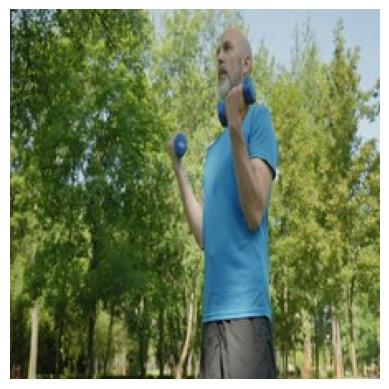

In [33]:
import matplotlib.pyplot as plt

x = 0
y = 14
plt.imshow(X_loaded[x][y] )
plt.axis('off')
plt.show()

In [140]:
model_path = r'E:\PosePerfect\Model\mobilenetV3_checkpoints\model_epoch_09_val_loss_0.35.keras'
cnn_lstm_model = load_model(model_path)

In [34]:
example_input = np.memmap(
    r'E:\PosePerfect\Model\Process Example\X_exam_16.dat',
    dtype='float32',
    mode='r',
    shape=(1, 15, 224, 224, 3)
)

example_input_writable = np.array(example_input) 

example_input_preprocessed = preprocess_input(example_input_writable)
print("Input preprocessed successfully!")

print(f"Input Shape: {example_input_preprocessed.shape}")
print(f"Input Summary: Min={example_input_preprocessed.min()}, Max={example_input_preprocessed.max()}, Mean={example_input_preprocessed.mean()}")

predictions = cnn_lstm_model.predict(example_input_preprocessed)
predicted_class = np.argmax(predictions, axis=1)

print("Raw Predictions:", predictions)
print("Predicted Class Probabilities:", predictions[0]) 
print(f"Predicted Class: {predicted_class}")

Input preprocessed successfully!
Input Shape: (1, 15, 224, 224, 3)
Input Summary: Min=0.0, Max=1.0, Mean=0.3883363902568817
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Raw Predictions: [[0.8868356  0.11316436]]
Predicted Class Probabilities: [0.8868356  0.11316436]
Predicted Class: [0]
